# Earthquake Damage Assessment

In this notebook, we will perform an **earthquake damage and risk assessment** for transportation infrastructure, specifically focusing on roads. The assessment is based on combining hazard data (e.g., PGA levels) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., roads) and hazard data (e.g., PGA levels) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on transportation infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner
#!pip install contextily
#!pip install exactextract

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from tqdm import tqdm

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.config import DICT_CIS_VULNERABILITY_FLOOD
from statistics import mode


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Tajikistan'
country_iso3 = 'TJK'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for Tajikistan. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. In case of locally available data, one can load the shapefiles through **gpd.read_file()**, as we show in the second cell within this section.

In [4]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the road data.

In [5]:
%%time
features = read_osm_data(infrastructure_path,asset_type='roads')

CPU times: total: 5.52 s
Wall time: 8.94 s


In [6]:
sub_types = features.object_type.unique()

In [7]:
sub_types

<ArrowStringArray>
[       'primary',          'trunk',          'track',       'tertiary',
      'secondary', 'secondary_link',    'residential',   'primary_link',
     'trunk_link',   'unclassified',  'tertiary_link',           'road']
Length: 12, dtype: str

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/475 earthquake hazard map to showcase the approach.

In [8]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/PGA_475y.tif", engine="rasterio")

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

In [9]:
maxdam_dict = {'trunk':2000, 
               'motorway' : 2000,
                'primary':2000, 
                'secondary':1300, 
                'tertiary':700, 
                'trunk_link': 1300,
                'motorway_link' : 1300,
                'primary_link' : 1300,
               'secondary_link' : 700,
               'tertiary_link' : 700,
               'track' : 300,
               'unclassified' : 300,
               'road' : 300,
               'residential' : 300
              }

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [10]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

And check if any of the objects are missing from the dataframe.

In [11]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics. The study by Nirandjan et al. (2024) provides us with a baseline set of fragility and vulnerability curves that one can use. In the following cell, we load that data.

In [12]:
vulnerability_path = "https://zenodo.org/records/13889558/files/Table_D2_Hazard_Fragility_and_Vulnerability_Curves_V1.1.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='E_Vuln_PGA ')

And let's have a look at all the available options

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure type,Infrastructure type details
E1.1,Power plant,Small generation facilities with anchored components
E1.1a,Power plant,Small generation facilities with anchored components
E1.1b,Power plant,Small generation facilities with anchored components
E1.2,Power plant,Small generation facilities with unanchored components
E1.2a,Power plant,Small generation facilities with unanchored components
E1.2b,Power plant,Small generation facilities with unanchored components
E1.3,Power plant,Medium/large power with anchored components
E1.3a,Power plant,Medium/large power with anchored components
E1.3b,Power plant,Medium/large power with anchored components


And select a curve to use for each different subtype we are analysing.

In [14]:
sub_types

<ArrowStringArray>
[       'primary',          'trunk',          'track',       'tertiary',
      'secondary', 'secondary_link',    'residential',   'primary_link',
     'trunk_link',   'unclassified',  'tertiary_link',           'road']
Length: 12, dtype: str

In [15]:
selected_curves = dict(zip(sub_types,['E8.9','E8.9','E8.9','E8.9','E8.9','E8.9','E8.9','E8.9',
                                      'E8.9','E8.9','E8.9','E8.9','E8.9','E8.9'])) #NOTE: these are incorrect curves for Roads. This is an example.

The next step is to extract the curves from the database, and prepare them for proper usage into our analysis.

We start by selecting the curve IDs from the larger pandas DataFrame **vul_df**:

In [16]:
damage_curves = vul_df[['ID number']+list(selected_curves.values())]
damage_curves = damage_curves.iloc[4:125,:]

Then for convenience, we rename the index name to the hazard intensity we are considering. 

In [17]:
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('PGA')  

And make sure that our damage values are in floating numbers. 

In [18]:
damage_curves = damage_curves.astype(np.float32)

And ensure that the columns of the curves link back to the different asset types we are considering:

In [19]:
damage_curves.columns = sub_types

There could be some **NaN** values at the tail of some of the curves. To make sure the code works, we fill up the **NaN** values with the last value of each of the curves. 

In [20]:
damage_curves = damage_curves.ffill()

Finally, make sure we set the index of the damage curves (the PGA levels) in the same metric as the hazard data.

In [21]:
damage_curves.index = damage_curves.index*980

### Ancilliary data for processing

In [22]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [23]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Preparing the Data

Clip the hazard data to the country of interest.

In [24]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [25]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

## 4. Performing an Exposure Assessment
We will use the DamageScanner approach. This is a fully optimised damage calculation method, that can capture a wide range of inputs to perform a damage assessment. It also allows to only assess the potential exposure.

In [26]:
exposure_results = DamageScanner(hazard_country, features, damage_curves, maxdam).exposure()

convert coverage to meters: 100%|██████████████████████████████████████████████| 91431/91431 [00:38<00:00, 2362.48it/s]


## 5. Performing a Vulnerability Assessment
In some cases, the cost information is unavailable, or one wants to explore only the exposure and vulnerability. To do so, we simply run the DamageScanner, by setting the maximum costs to 1.

In [27]:
vulnerability_maxdam = maxdam.copy()
vulnerability_maxdam.loc[:,'damage'] = maxdam['damage']/maxdam['damage']

In [45]:
%%time
vulnerability_results = DamageScanner(hazard_country, features, damage_curves, vulnerability_maxdam).calculate(return_full=False)

Calculating damage: 100%|██████████████████████████████████████████████████████| 91384/91384 [00:09<00:00, 9326.01it/s]

CPU times: total: 43.5 s
Wall time: 58.7 s


Important for the earthquake assessment, is the fact that liquefaction can be an important driver of the damages, especially for road and railways. As such, we also overlay our results with a [global liquefaction map](https://zenodo.org/records/2583746), to be able to correct the results.

In [38]:
liqeufaction_map = xr.open_dataset("https://zenodo.org/records/2583746/files/liquefaction_v1_deg.tif", engine="rasterio")

In [39]:
liqeufaction_country = liqeufaction_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    ).copy(deep=True)


In [46]:
liquefaction_results = DamageScanner(liqeufaction_country, features, damage_curves, maxdam).exposure(return_full=False)

convert coverage to meters: 100%|██████████████████████████████████████████████| 91384/91384 [00:23<00:00, 3948.36it/s]


Based on the Supplementary Table S6 as provided by [Koks et al (2019)](https://www.nature.com/articles/s41467-019-10442-3), we identify which combinations of liquefaction and earthquake intensity should result in damages.

In [47]:
damage_dict = {
    (1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0,
    (2, 1): 1, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0,
    (3, 1): 1, (3, 2): 1, (3, 3): 0, (3, 4): 0, (3, 5): 0,
    (4, 1): 1, (4, 2): 1, (4, 3): 1, (4, 4): 0, (4, 5): 0,
    (5, 1): 1, (5, 2): 1, (5, 3): 1, (5, 4): 1, (5, 5): 0,
    (6, 1): 0, (6, 2): 0, (6, 3): 0, (6, 4): 0, (6, 5): 0,
}

To make things efficient, below we have written a small function to identify those assets that may or may not have damage. If they fall within a damage category, they receive a '1', if they do not fall within a damage category, they receive a '0'.

In [48]:
def get_damage_bool(feature,liquefaction_results,damage_dict):

    liq_value = mode(liquefaction_results.loc[feature.name]['values'])

    if int(liq_value) == 0:
        return 0
    
    eq_value = mode(np.digitize(feature['values'], bins=[0, 0.092*980, 0.18*980, 0.34*980, 0.65*980, float('inf')]))

    return damage_dict[(eq_value,liq_value)]

In [49]:
tqdm.pandas(desc='liquefaction correction boolean')
vulnerability_results['liquefaction_corr'] = vulnerability_results.progress_apply(lambda feature: get_damage_bool(feature,liquefaction_results,damage_dict),axis=1)
vulnerability_results['vuln_corrected'] = vulnerability_results['damage']*vulnerability_results['liquefaction_corr']

liquefaction correction boolean: 100%|█████████████████████████████████████████| 91384/91384 [00:14<00:00, 6254.81it/s]


## 6. Performing the Damage Assessment
In case we do have cost values, we can fully assess the damages.

In [50]:
%%time
damage_results = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate(return_full=False)

Calculating damage: 100%|██████████████████████████████████████████████████████| 91384/91384 [00:10<00:00, 9011.19it/s]

CPU times: total: 47.2 s
Wall time: 1min 4s


And again, we correct for the liquefaction

In [51]:
tqdm.pandas(desc='liquefaction correction boolean')
damage_results['liquefaction_corr'] = damage_results.progress_apply(lambda feature: get_damage_bool(feature,liquefaction_results,damage_dict),axis=1)
damage_results['damage_corrected'] = damage_results['damage']*damage_results['liquefaction_corr']

liquefaction correction boolean: 100%|█████████████████████████████████████████| 91384/91384 [00:15<00:00, 5750.81it/s]


## 7. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit. We show how to do this using the damage results.

In [52]:
hazard = 'earthquake'
return_period = '1_475'
damage_results.to_file(f'Road_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

In [53]:
admin1_country = admin1.loc[admin1.sov_a3 == country_iso3]

In [54]:
damage_results = damage_results.sjoin(admin1_country[['adm1_code','name','geometry']])

## 8. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

Find the locations of the twenty most damaged roads.

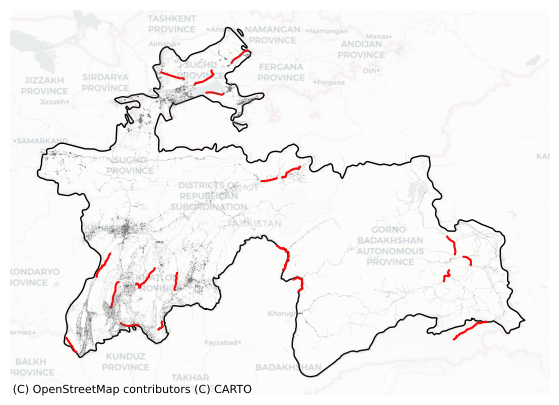

In [55]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

damage_results.to_crs(3857).sort_values('damage_corrected',ascending=False).head(20).plot(ax=ax,color='Red')
features.to_crs(3857).plot(ax=ax,facecolor="none",edgecolor='grey',alpha=0.5,zorder=2,lw=0.1)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

And create a distribution of the damages.

<Axes: xlabel='damage', ylabel='Count'>

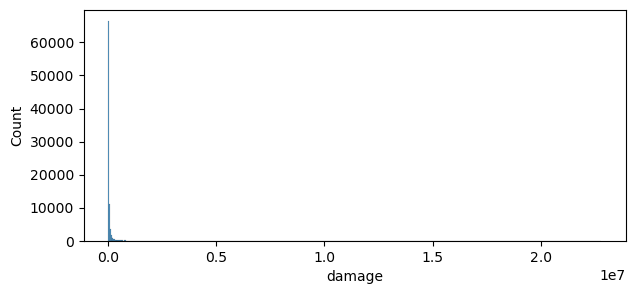

In [56]:
fig, ax = plt.subplots(1,1,figsize=(7, 3))

sns.histplot(data=damage_results,x='damage',ax=ax)

Plot all damages

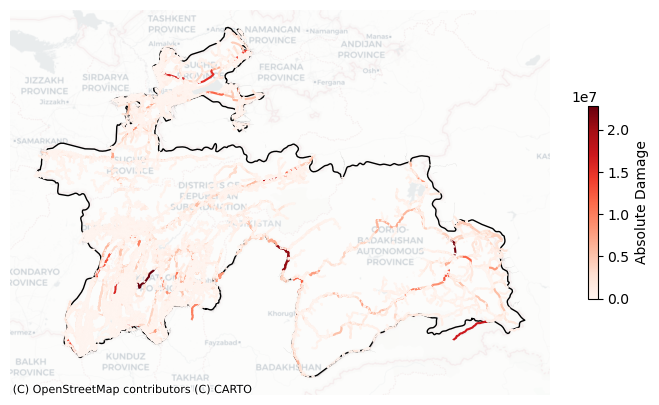

In [57]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

damage_results.to_crs(3857).plot(ax=ax,column='damage_corrected',cmap='Reds',legend=True,
                   legend_kwds={'shrink': 0.5,'label':'Absolute Damage'},zorder=5)
features.to_crs(3857).plot(ax=ax,facecolor="none",edgecolor='grey',alpha=0.5,zorder=2,lw=0.1)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()